# Blood spot computer vision demo

This Jupyter notebook aims to to demonstrate the use of the computer vision code for assessing blood spot quality, developed by [Nick Flynn](https://www.linkedin.com/in/flynnn) of Cambridge University Hospitals NHS Foundation Trust.

The code was developed for a project submitted to the Royal College of Pathologists to satisfy the requirements of the Part 2 Module 3 (Writen Component Module) FRCPath examination in Clinical Biochemistry.

The code has been licenced under a [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.en.html).

Please cite the following paper if you use this code:

Nick Flynn, Stuart J. Moat, Sarah L. Hogg, A computer vision approach to the assessment of dried blood spot size and quality in newborn screening, Clinica Chimica Acta, Volume 547, 2023, 117418, ISSN 0009-8981, https://doi.org/10.1016/j.cca.2023.117418.

For questions or comments please contact nick.flynn@nhs.net

## Set-up

### Anaconda environment

Anaconda is an open source distribution platform and can be downloaded from https://www.anaconda.com/.

The anaconda environment used for this study is contained within the ```nbscv.yaml``` file.

To create the environment, open Anaconda prompt and change directory using the ```cd``` prompt to the folder in which the ```nbscv.yaml``` file has been saved.

```
(base) C:\Users\nickf> cd C:\Users\nickf\Anaconda3\envs
```

Next create the conda environment using ```conda env create -f nbscv.yaml```

```
(base) C:\Users\nickf\Anaconda3\envs> conda env create -f nbscv.yaml
```

To activate the environment use

```
$ conda activate nbscv_demo
```

### Import dependencies

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import math

### Search areas and pixel conversion

In [17]:
# Default coordinates for outer rectangle
# This rectangle defines the region that the blood spot must fall completely within
x_min=1
x_max=459
y_min=50
y_max=299

# Default coordinates and radius for search area - these may need tweaking depending on the configuration of the Panthera puncher
center = (209,139)
radius = 68

# Default mm-per-pixel - instrument specific value can be found in the config file of the Panthera puncher
mm_per_pixel = 0.1153

### Machine learning model and columns

In [18]:
### Load machine learning models
from joblib import load
scaler = load('log_model_scaler_220828.joblib')
log_model = load('log_model_final_220828.joblib') 

### Define column names

cols = ['contour_index','area','perimeter_mm','roundness','equiv_diam_mm', 
        'long_mm','short_mm', 'elongation', 'circular_extent',
         'hull_area', 'solidity', 'hull_perimeter', 'convexity', 
        'number_punches', 'average_punch_area','average_punch_mm_dist_from_center',
                             'average_punch_dist_from_center_prop']

ml_cols = ['roundness','elongation','circular_extent','solidity','convexity']

# Blood spot detection

In [19]:
## Import functions necessary for blood spot detection
from functions import contour_in_roi, all_contour_in_roi, bs_detect, draw_bs_contours, spot_metrics, calc_multispot_prob,  draw_bounding_box

Load image from Panthera camera, crop and convert to RGB colour space

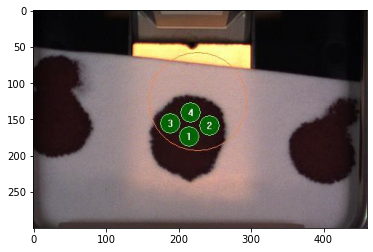

In [20]:
img = cv2.imread('images/demo1.jpg')

## we are only interested in the central region, so crop with the following settings
img = img[0:300, 150:610]

## openCV uses BGR colour space, while matplotlib uses RGB
## since we are using matplotlib to display images, convert to RGB colour space
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

## display image to show the cropped image
plt.imshow(img_rgb)

Blood spots are detected using the bs_detect function.

We can ```select_punched=True``` to select only blood spots with punch annotations, or set ```select_punched=False``` to select all blood spots within the region of interest.

In this case, let's select all blood spots with ```select_punched=False``` .

```draw_bs_contours``` draws the detected blood spots on the image in blue

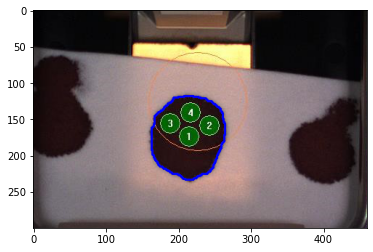

In [21]:
## contours and hierarchy of punched spots are detected using the bs_detect function
contours, hierarchy = bs_detect(img, x_min, x_max, y_min, y_max, select_punched=False)

# draw contours
contour_img = draw_bs_contours(img_rgb.copy(),contours,hierarchy, center, radius, select_punched=False)

plt.imshow(contour_img)

We can then calculate blood spot properties from the detection blood spot contours. The list of values corresponds to the cols listed above.

Properties related to punches are equal to False since we are not looking for punched spots

In [22]:
# calculate properties
spot_met = spot_metrics(contours,hierarchy,mm_per_pixel,center,radius, select_punched=False)
spot_met


[[1,
  9107.5,
  42.177446616268156,
  0.9248121884614725,
  12.416064401072743,
  13.126062100982667,
  11.763494111633301,
  0.896193696261169,
  0.8480379542165076,
  9313.0,
  0.9779340706539246,
  346.8920201063156,
  0.9482947197384676,
  0,
  False,
  False,
  False]]

We can calculate the probability of an incorrect application blood spot using the ```calc_multispot_prob``` function.

In [23]:
prob_ms_list = calc_multispot_prob(spot_met,cols,ml_cols,scaler,log_model)
prob_ms_list

[(1, 0.0196)]

This says that the predicted class is 1 ('Single spot') with a probability of belonging to the incorrect application class (class 0) of 0.0196.

We can draw a colour coded bounded box on the image, together with the measured diameter (upper left) and incorrect application probability (lower right)

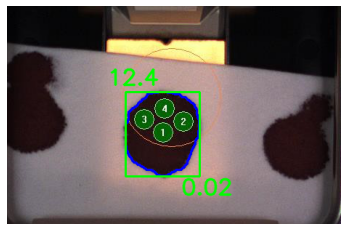

In [24]:
# draw bounding box
bounding_box_img = draw_bounding_box(contour_img.copy(),contours,hierarchy, center, radius, spot_met,
                                     multispot_prob_list=prob_ms_list, select_punched=False, diam_range = (8,14),
                             prob_multi_limit = 0.50)

plt.axis('off')
plt.imshow(bounding_box_img)

# Punched blood spot detection

We can detect a punched blood spot in the same way as above, except we set ```select_punched = True```

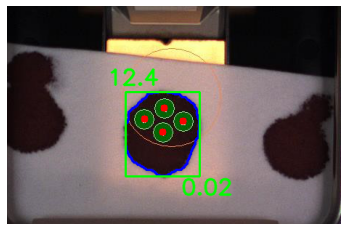

In [25]:
img = cv2.imread('images/demo1.jpg')

## we are only interested in the central region, so crop with the following settings
img = img[0:300, 150:610]

## openCV use BGR colour space, while matplotlib uses RGB
## since we are using matplotlib to display images, convert to RGB colour space
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

## contours and hierarchy of punched spots are detected using the bs_detect function
contours, hierarchy = bs_detect(img, x_min, x_max, y_min, y_max, select_punched=True)

# draw contours
contour_img = draw_bs_contours(img_rgb.copy(),contours,hierarchy, center, radius, select_punched=True)

# calculate properties
spot_met = spot_metrics(contours,hierarchy,mm_per_pixel,center,radius, select_punched=True)

# calculate incorrect application probability
prob_ms_list = calc_multispot_prob(spot_met,cols,ml_cols,scaler,log_model)

# draw bounding box
bounding_box_img = draw_bounding_box(contour_img.copy(),contours,hierarchy, center, radius, spot_met,
                                     multispot_prob_list=prob_ms_list, select_punched=True, diam_range = (8,14),
                             prob_multi_limit = 0.50)

plt.axis('off')
plt.imshow(bounding_box_img)

The position of punches are indicated by the red dots

# Analysis of multiple images

If we have multiple images that we wish to analyse, then we can use the ```spot_metrics_multi``` and ```calc_multispot_prob_multi``` functions

In [26]:
from functions import spot_metrics_multi, calc_multispot_prob_multi

```spot_metrics_multi``` detects spots and calculates blood spot metrics on all images within a folder. The images must all be of the same type:

- 'screenshot' - a screenshot from the Panthera PC
- 'original' - the original view from the Panthera camera
- 'cropped' - an image which has been cropped to within the gripping hand

The function returns a pandas dataframe

In [27]:
df = spot_metrics_multi(
    'images',
    x_min,
    x_max,
    y_min,
    y_max,
    mm_per_pixel,
    center,
    radius,
    image_type='original',
    select_punched=True,
)

df

,file,contour_index,area,perimeter_mm,roundness,equiv_diam_mm,long_mm,short_mm,elongation,circular_extent,hull_area,solidity,hull_perimeter,convexity,number_punches,average_punch_area,average_punch_dist_from_center_mm,average_punch_dist_from_center_prop
0,demo1,1,9107.5,42.177447,0.924812,12.416064,13.126062,11.763494,0.896194,0.848038,9313.0,0.977934,346.892020,0.948295,4,51.75,2.789849,0.224697
1,demo2,1,6612.0,35.794976,0.928493,10.579150,10.953500,9.915800,0.905263,0.853894,6750.0,0.979556,294.904723,0.949924,4,69.50,2.448761,0.231470


We can then calculate the probability of an incorrectly applied blood spot on all rows, and add these to the dataframe.

In [28]:
df = calc_multispot_prob_multi(df,ml_cols,scaler,model=log_model,scale=True)
df

,file,contour_index,area,perimeter_mm,roundness,equiv_diam_mm,long_mm,short_mm,elongation,circular_extent,...,solidity,hull_perimeter,convexity,number_punches,average_punch_area,average_punch_dist_from_center_mm,average_punch_dist_from_center_prop,pred_multi,prob_multi,prob_control
0,demo1,1,9107.5,42.177447,0.924812,12.416064,13.126062,11.763494,0.896194,0.848038,...,0.977934,346.892020,0.948295,4,51.75,2.789849,0.224697,controls,0.019591,0.980409
1,demo2,1,6612.0,35.794976,0.928493,10.579150,10.953500,9.915800,0.905263,0.853894,...,0.979556,294.904723,0.949924,4,69.50,2.448761,0.231470,controls,0.008752,0.991248
